Notebook to debug the MCS + NLLS approach.

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib qt

In [2]:
import os
import sys
from pathlib import Path

In [3]:
src_dir = str(Path(os.getcwd()).parent / "src")
sys.path.insert(1, src_dir)
#os.environ["PYTHONPATH"] = src_dir

In [4]:
import data_loader
import calculate_concentr_diffs
from concentr_diffs_pathlength import *
from plotting import *
from mbll_functions import *
from utils import *
from mcs_function import *
from pathlib import Path
import config
import pickle
from ray import tune
import pmcx
import scipy

import matplotlib.pyplot as plt

In [5]:
config.data_dir

PosixPath('/home/leon_ivan/data')

In [6]:
config.spectra_dir

PosixPath('/home/leon_ivan/nonlinear-fit/dataset/UCL-NIR-Spectra/spectra')

In [7]:
config.gpuid

4

In [8]:
loader = data_loader.DataLoaderHELICOID(
    config.dataset_dir,
    wavelength_left_cut=520,
    wavelength_right_cut=850,
    num_wavelengths=20
)

delta_A_gt_img = loader.get_attenuation_change("020-01")
A_gt_img = loader.get_attenuation("020-01")

mu_a_matrix_old = loader.absorption_coefs_old(
    use_diff_oxycco=False,
    use_water_and_fat=True
)

mu_a_matrix = loader.absorption_coefs(
    use_diff_oxycco=False,
    use_water_and_fat=True
)

mu_a_matrix_static = data_loader.DataLoader.absorption_coefs(
    loader.wavelengths,
    use_diff_oxycco=False,
    use_water_and_fat=True
)

print(np.allclose(mu_a_matrix, mu_a_matrix_static))
print(np.max(np.abs(mu_a_matrix - mu_a_matrix_static)))

True
0.0


/home/leon_ivan/miniconda3/envs/nonlinear-fit/lib/python3.11/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


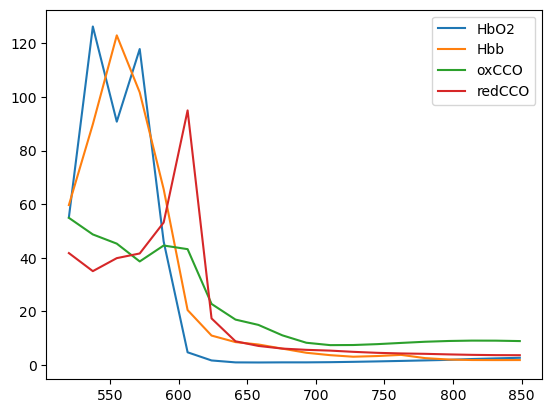

In [9]:
plot_spectra(mu_a_matrix_old[:, :4].T, loader.wavelengths, ["HbO2", "Hbb", "oxCCO", "redCCO", "Water", "Fat"])

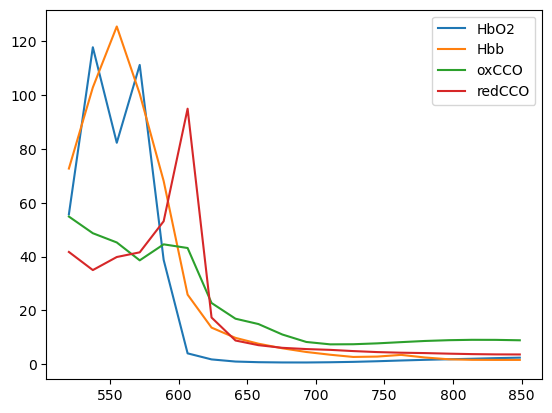

In [10]:
plot_spectra(mu_a_matrix[:, :4].T, loader.wavelengths, ["HbO2", "Hbb", "oxCCO", "redCCO", "Water", "Fat"])

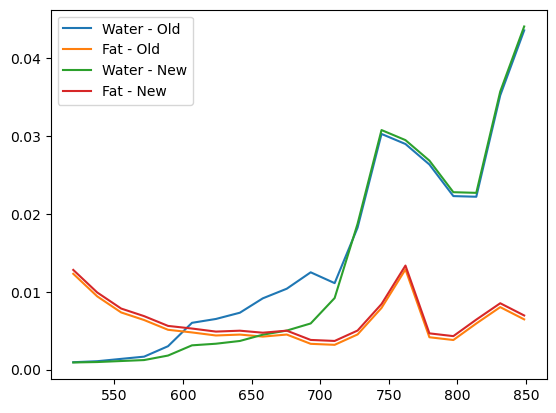

In [11]:
plot_spectra((*(mu_a_matrix_old[:, -2:].T), *(mu_a_matrix[:, -2:].T + 0.0005)), loader.wavelengths, ["Water - Old", "Fat - Old", "Water - New", "Fat - New"])

In [12]:
mu_a_matrix_old[:, -2] / mu_a_matrix[:, -2]

array([2.3025851 , 2.30126438, 2.30221382, 2.30437163, 2.30937602,
       2.29913441, 2.30553602, 2.30155176, 2.29933248, 2.30436851,
       2.30360355, 1.27811221, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [13]:
loader.wavelengths

array([520.        , 537.45454545, 554.90909091, 571.63636364,
       589.09090909, 606.54545455, 624.        , 641.45454545,
       658.18181818, 675.63636364, 693.09090909, 710.54545455,
       727.27272727, 744.72727273, 762.18181818, 779.63636364,
       797.09090909, 813.81818182, 831.27272727, 848.72727273])

In [14]:
mcs_obj1 = SimulationAttenuation(config.mcs_func_path.parent / "function_data1.npz")
mcs_obj2 = SimulationAttenuation(config.mcs_func_path.parent / "function_data2.npz")

Loaded data with 100000.0 photons and 30 values for mu_s.
Loaded data with 100000.0 photons and 30 values for mu_s.


Create spectrum with MCS and compare to MCS-func

In [15]:
#g_combined = 0.8675
g_combined = 0.9
refractive_index_combined = 1.38
vol = np.ones((50, 50, 500))
prop = np.array([[0, 0, 1, 1], [0, 0, g_combined, refractive_index_combined]])
unitinmm = 1

In [16]:
cfg = {
    "nphoton": 5e6, 
    "maxdetphoton": 5e6,
    "unitinmm": unitinmm,
    "vol": vol,
    "tstart":0,
    "tend":1e-8,
    "tstep":1e-8,
    "autopilot": 1,
    "gpuid": config.gpuid,
    "prop":prop,
    "bc": "ccrcca001000", # mark z=0 plane as detector
    "srcdir": [0,0,1],
    "srctype": "planar",
    "srcpos": [0, 0, 0],
    "srcparam1": [vol.shape[0], 0, 0, 0], # 3D position of vertex, fourth coordinate is irrelevant
    "srcparam2": [0, vol.shape[1], 0, 0],
    "issrcfrom0": 1,
    "savedetflag": "dps", # detector id, path length, scatter count
    "flog": config.mcs_func_path / "log.txt",
}

In [17]:
mu_a_vals = loader.mu_a_func_gray_matter(loader.wavelengths)
mu_s_vals = loader.mu_s_red_func_gray_matter(loader.wavelengths) / (1-g_combined)

In [18]:
with open(config.result_dir / "A_mcs_generated", "rb") as f:
    A_mcs_generated = pickle.load(f)

In [18]:
skip_simulation = False

In [19]:
if not skip_simulation:
    A_mcs_generated = np.empty((loader.wavelengths.shape[0],))

    for i, wl in enumerate(loader.wavelengths):
        cfg["prop"][1, 0] = mu_a_vals[i] / 10
        cfg["prop"][1, 1] = mu_s_vals[i] / 10
        cfg["prop"][1, 2] = g_combined
        cfg["prop"][1, 3] = refractive_index_combined
        print(f"Iteration {i}/{loader.wavelengths.shape[0]}")
        res = pmcx.mcxlab(cfg)
        weights = pmcx.utils.detweight(res["detp"])
        attenuation = -np.log(np.sum(weights)/cfg["nphoton"])
        A_mcs_generated[i] = attenuation

Iteration 0/20
nphoton: 5e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 5e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1
Iteration 1/20
nphoton: 5e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 5e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Iteration 2/20
nphoton: 5e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 5e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1


                                      #
#Please visit our free scientific data sharing portal at https://neurojson.io #
# and consider sharing your public datasets in standardized JSON/JData format #
###############################################################################
$Rev::0fcc04 $ v2025 $Date::2025-02-12 23:26:11 -05$ by $Author::Qianqian Fang$
###############################################################################
- code name: [Fermi MCX] compiled by nvcc [9.2] for CUDA-arch [350] on [Feb 13 2025]
- compiled with: RNG [xorshift128+] with Seed Length [4]

GPU=4 (Quadro RTX 8000) threadph=33 extra=133952 np=5000000 nthread=147456 maxgate=1 repetition=1
initializing streams ...	init complete : 0 ms
requesting 1792 bytes of shared memory
launching MCX simulation for time window [0.00e+00ns 1.00e+01ns] ...
simulation run# 1 ... 
kernel complete:  	2290 ms
retrieving fields ... 	detected 4833683 photons, total: 4833683	transfer complete:	2341 ms
normalizing raw data ...

Iteration 3/20
nphoton: 5e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 5e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1


                                      #
#Please visit our free scientific data sharing portal at https://neurojson.io #
# and consider sharing your public datasets in standardized JSON/JData format #
###############################################################################
$Rev::0fcc04 $ v2025 $Date::2025-02-12 23:26:11 -05$ by $Author::Qianqian Fang$
###############################################################################
- code name: [Fermi MCX] compiled by nvcc [9.2] for CUDA-arch [350] on [Feb 13 2025]
- compiled with: RNG [xorshift128+] with Seed Length [4]

GPU=4 (Quadro RTX 8000) threadph=33 extra=133952 np=5000000 nthread=147456 maxgate=1 repetition=1
initializing streams ...	init complete : 0 ms
requesting 1792 bytes of shared memory
launching MCX simulation for time window [0.00e+00ns 1.00e+01ns] ...
simulation run# 1 ... 
kernel complete:  	2152 ms
retrieving fields ... 	detected 4825539 photons, total: 4825539	transfer complete:	2202 ms
normalizing raw data ...

Iteration 4/20
nphoton: 5e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 5e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Iteration 5/20
nphoton: 5e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 5e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Iteration 6/20
nphoton: 5e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 5e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Iteration 7/20
nphoton: 5e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 5e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1
Iteration 8/20
nphoton: 5e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 5e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Iteration 9/20
nphoton: 5e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 5e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1


	source 1, normalization factor alpha=20.000000
data normalization complete : 1803 ms
simulated 5000000 photons (5000000) with 147456 threads (repeat x1)
MCX simulation speed: 2913.75 photon/ms
total simulated energy: 5000000.00	absorbed: 42.04711%
(loss due to initial specular reflection is excluded in the total)


Iteration 10/20
nphoton: 5e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 5e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Iteration 11/20
nphoton: 5e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 5e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Iteration 12/20
nphoton: 5e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 5e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1


                                      #
#Please visit our free scientific data sharing portal at https://neurojson.io #
# and consider sharing your public datasets in standardized JSON/JData format #
###############################################################################
$Rev::0fcc04 $ v2025 $Date::2025-02-12 23:26:11 -05$ by $Author::Qianqian Fang$
###############################################################################
- code name: [Fermi MCX] compiled by nvcc [9.2] for CUDA-arch [350] on [Feb 13 2025]
- compiled with: RNG [xorshift128+] with Seed Length [4]

GPU=4 (Quadro RTX 8000) threadph=33 extra=133952 np=5000000 nthread=147456 maxgate=1 repetition=1
initializing streams ...	init complete : 0 ms
requesting 1792 bytes of shared memory
launching MCX simulation for time window [0.00e+00ns 1.00e+01ns] ...
simulation run# 1 ... 
kernel complete:  	1524 ms
retrieving fields ... 	detected 4744238 photons, total: 4744238	transfer complete:	1574 ms
normalizing raw data ...

Iteration 13/20
nphoton: 5e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 5e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Iteration 14/20
nphoton: 5e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 5e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1


                                      #
#Please visit our free scientific data sharing portal at https://neurojson.io #
# and consider sharing your public datasets in standardized JSON/JData format #
###############################################################################
$Rev::0fcc04 $ v2025 $Date::2025-02-12 23:26:11 -05$ by $Author::Qianqian Fang$
###############################################################################
- code name: [Fermi MCX] compiled by nvcc [9.2] for CUDA-arch [350] on [Feb 13 2025]
- compiled with: RNG [xorshift128+] with Seed Length [4]

GPU=4 (Quadro RTX 8000) threadph=33 extra=133952 np=5000000 nthread=147456 maxgate=1 repetition=1
initializing streams ...	init complete : 0 ms
requesting 1792 bytes of shared memory
launching MCX simulation for time window [0.00e+00ns 1.00e+01ns] ...
simulation run# 1 ... 
kernel complete:  	1418 ms
retrieving fields ... 	detected 4725837 photons, total: 4725837	transfer complete:	1472 ms
normalizing raw data ...

Iteration 15/20
nphoton: 5e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 5e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Iteration 16/20
nphoton: 5e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 5e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Iteration 17/20
nphoton: 5e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 5e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Iteration 18/20
nphoton: 5e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 5e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1


                                      #
#Please visit our free scientific data sharing portal at https://neurojson.io #
# and consider sharing your public datasets in standardized JSON/JData format #
###############################################################################
$Rev::0fcc04 $ v2025 $Date::2025-02-12 23:26:11 -05$ by $Author::Qianqian Fang$
###############################################################################
- code name: [Fermi MCX] compiled by nvcc [9.2] for CUDA-arch [350] on [Feb 13 2025]
- compiled with: RNG [xorshift128+] with Seed Length [4]

GPU=4 (Quadro RTX 8000) threadph=33 extra=133952 np=5000000 nthread=147456 maxgate=1 repetition=1
initializing streams ...	init complete : 0 ms
requesting 1792 bytes of shared memory
launching MCX simulation for time window [0.00e+00ns 1.00e+01ns] ...
simulation run# 1 ... 
kernel complete:  	1245 ms
retrieving fields ... 	detected 4685076 photons, total: 4685076	transfer complete:	1298 ms
normalizing raw data ...

Iteration 19/20
nphoton: 5e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 5e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

In [20]:
print(config.result_dir)

/home/leon_ivan/data/results


In [21]:
with open(config.result_dir / "A_mcs_generated", "wb") as f:
    pickle.dump(A_mcs_generated, f)

In [22]:
A_mcs_func_computed1 = mcs_obj1.A_concentrations(
    loader.wavelengths, 
    mu_a_matrix, 
    loader.params_ref_gray_matter[:6],
    *loader.params_ref_gray_matter[-2:]
)

A_mcs_func_computed2 = mcs_obj2.A_concentrations(
    loader.wavelengths, 
    mu_a_matrix, 
    loader.params_ref_gray_matter[:6],
    *loader.params_ref_gray_matter[-2:]
)

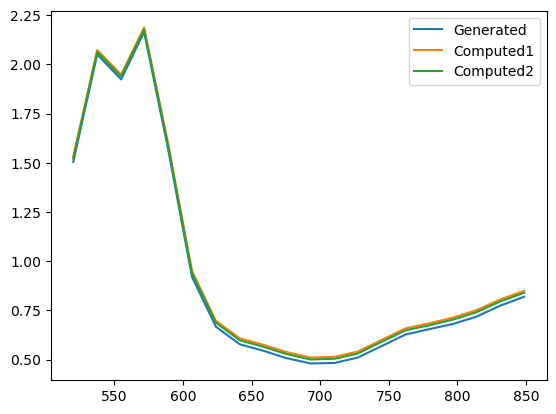

In [23]:
plot_spectra(
    (A_mcs_generated, A_mcs_func_computed1 + 0.03, A_mcs_func_computed2 + 0.02),
    loader.wavelengths,
    labels=["Generated", "Computed1", "Computed2"]
)

In [24]:
A_mcs_generated / A_mcs_func_computed1[:, 0]

array([1.00120255, 1.0036384 , 1.00270001, 1.0032844 , 1.00084793,
       1.0002983 , 0.99954418, 0.9994594 , 0.99947758, 0.99886722,
       0.99955037, 0.99734755, 0.99927296, 0.99723589, 0.99808776,
       1.00050822, 0.99653144, 0.9959647 , 0.99791271, 0.99977085])

Test fitting with single-thread and without jacobian. See if fitting procedure converges to reference gray matter concentrations, when initialized with slightly perturbed reference concentrations.

In [32]:
init_vals = loader.params_ref_gray_matter + np.array([0.05, 0.025, 0.001, 0.0005, 0.05, 0.15, 2, 0.5])
print(init_vals)

[1.146e-01 3.640e-02 7.400e-03 2.100e-03 7.800e-01 2.500e-01 4.280e+01
 3.589e+00]


In [33]:
concentrations_to_blood_fraction(init_vals)

array([6.49300000e-02, 7.58940397e-01, 7.40000000e-03, 2.10000000e-03,
       7.80000000e-01, 2.50000000e-01, 4.28000000e+01, 3.58900000e+00])

In [34]:
loader.params_ref_gray_matter_fraction

array([3.268e-02, 8.500e-01, 6.400e-03, 1.600e-03, 7.300e-01, 1.000e-01,
       4.080e+01, 3.089e+00])

In [36]:
%%time

params_mcs_flat, errors = concentr_fit_nonlinear(
    A_mcs_generated[:, None],
    loader.wavelengths,
    mu_a_matrix,
    mcs_obj1.A_blood_fraction,
    ref_vals=concentrations_to_blood_fraction(init_vals),
    variables_bool_arr=np.array([True, True, True, True, True, True, True, True]),
    left_bounds=np.array([0, 0, 0, 0, 0, 0, 3, 0.1]),
    right_bounds=np.array([1, 1, 0.01, 0.01, 1, 1, 100, 10]),
    is_delta_A=False,
    progress_bar=False,
    verbosity=2
)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3534e+00                                    5.77e+00    
       1              2         9.0929e-02      1.26e+00       1.01e+01       8.37e-01    
       2              3         1.9994e-03      8.89e-02       4.03e+00       8.84e-02    
       3              4         9.2739e-05      1.91e-03       7.52e-01       2.82e-03    
       4              5         9.6586e-06      8.31e-05       9.54e-01       4.71e-04    
       5              6         6.5701e-06      3.09e-06       2.30e-01       1.01e-03    
       6              8         6.4280e-06      1.42e-07       1.43e-01       5.08e-04    
       7             10         6.4026e-06      2.54e-08       8.32e-02       5.86e-05    
       8             12         6.3960e-06      6.59e-09       2.56e-02       2.24e-05    
       9             13         6.3901e-06      5.85e-09       1.61e-02       9.10e-05    

In [37]:
print(params_mcs_flat)

[[4.60792850e-02]
 [8.52377361e-01]
 [8.87702804e-03]
 [2.26996128e-03]
 [9.08521367e-01]
 [3.47068133e-01]
 [5.70989449e+01]
 [3.09173576e+00]]


In [38]:
A_init_reconstr = mcs_obj1.A_concentrations(
    loader.wavelengths,
    mu_a_matrix,
    init_vals[:6],
    *init_vals[-2:]
)

A_reconstr = mcs_obj1.A_blood_fraction(
    loader.wavelengths,
    mu_a_matrix,
    params_mcs_flat[:6, 0],
    *params_mcs_flat[-2:, 0]
)

with open(config.m_params_path, "rb") as f:
    m_params, A_vals, N_vals, dref_vals = pickle.load(f)

A_jacques_reconstr_combinedm = A_jacques_blood_fraction(
    loader.wavelengths,
    mu_a_matrix,
    params_mcs_flat[:6, 0],
    *params_mcs_flat[-2:, 0],
    *m_params[1.38]
)

A_jacques_reconstr_gmm = A_jacques_blood_fraction(
    loader.wavelengths,
    mu_a_matrix,
    params_mcs_flat[:6, 0],
    *params_mcs_flat[-2:, 0],
    *m_params[1.36]
)

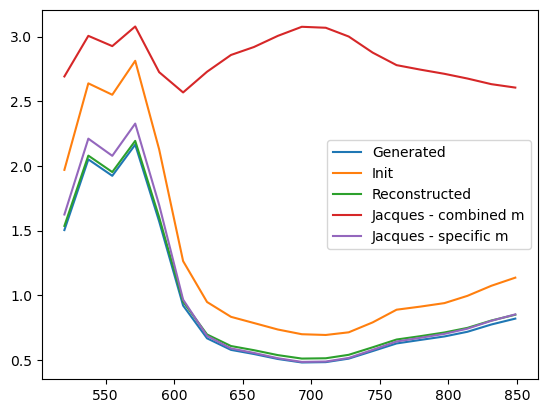

In [39]:
plot_spectra((A_mcs_generated, A_init_reconstr, A_reconstr + 0.03, A_jacques_reconstr_combinedm, A_jacques_reconstr_gmm), loader.wavelengths, ["Generated", "Init", "Reconstructed", "Jacques - combined m", "Jacques - specific m"])

Result: MCS-Func adjusts values so that reconstructed spectrum is essentially identical to input spectrum. Jacques only produces similar spectrum, if m-parameters for correct tissue type are used.

Compute the jacobian using numeric differentiation, and compare to analytic Jacobian.

In [42]:
eval_vals = loader.params_ref_blood_vessel_fraction
print(eval_vals)

[9.99320000e-01 7.90017212e-01 0.00000000e+00 0.00000000e+00
 5.50000000e-01 1.00000000e-02 2.20000000e+01 6.60000000e-01]


In [43]:
jac = mcs_obj1.jacobian_blood_fraction(loader.wavelengths, mu_a_matrix, eval_vals[:6], *eval_vals[-2:])

In [44]:
dx = 1e-7
x = np.tile(eval_vals[:, None], (1, 8))
x_dx = x + dx * np.eye(8)
jac_numeric = mcs_obj1.A_blood_fraction(loader.wavelengths, mu_a_matrix, x_dx[:-2,:], *x_dx[-2:, :]) - mcs_obj1.A_blood_fraction(loader.wavelengths, mu_a_matrix, x[:-2, :], *x[-2:, :])
jac_numeric /= dx

In [45]:
print(np.isclose(jac[:, 0, :], jac_numeric))

[[ True  True  True  True False  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True False False  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True

In [46]:
np.max(np.abs(jac[:, 0, :] - jac_numeric))

1.0979000526489813e-06

Test if using the jacobian works and produces the same results.

In [49]:
%%time

params_mcs_flat_jacobian, errors = concentr_fit_nonlinear(
    A_mcs_generated[:, None],
    loader.wavelengths,
    mu_a_matrix,
    mcs_obj1.A_blood_fraction,
    jacobian=mcs_obj1.jacobian_blood_fraction,
    ref_vals=concentrations_to_blood_fraction(init_vals),
    variables_bool_arr=np.array([True, True, True, True, True, True, True, True]),
    left_bounds=np.array([0, 0, 0, 0, 0, 0, 3, 0.1]),
    right_bounds=np.array([1, 1, 0.01, 0.01, 1, 1, 100, 10]),
    is_delta_A=False,
    progress_bar=False,
    verbosity=2
)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3534e+00                                    5.77e+00    
       1              2         9.0929e-02      1.26e+00       1.01e+01       8.37e-01    
       2              3         1.9994e-03      8.89e-02       4.03e+00       8.84e-02    
       3              4         9.2739e-05      1.91e-03       7.52e-01       2.82e-03    
       4              5         9.6586e-06      8.31e-05       9.54e-01       4.71e-04    
       5              6         6.5701e-06      3.09e-06       2.30e-01       1.01e-03    
       6              8         6.4280e-06      1.42e-07       1.43e-01       5.08e-04    
       7             10         6.4026e-06      2.54e-08       8.32e-02       5.86e-05    
       8             12         6.3960e-06      6.59e-09       2.56e-02       2.24e-05    
       9             13         6.3901e-06      5.85e-09       1.61e-02       9.10e-05    

In [52]:
A_reconstr_jacobian = mcs_obj1.A_blood_fraction(
    loader.wavelengths,
    mu_a_matrix,
    params_mcs_flat_jacobian[:6, 0],
    *params_mcs_flat_jacobian[-2:, 0]
)

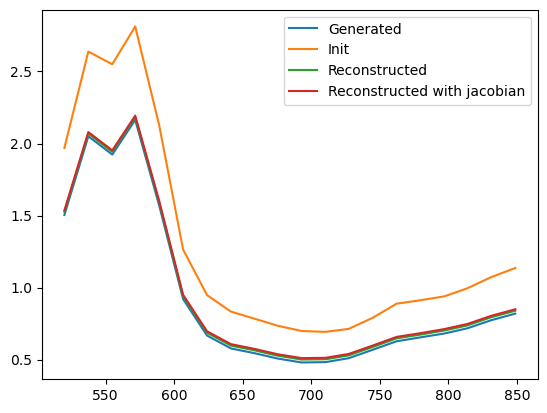

In [53]:
plot_spectra((A_mcs_generated, A_init_reconstr, A_reconstr + 0.02, A_reconstr_jacobian + 0.03), loader.wavelengths, ["Generated", "Init", "Reconstructed", "Reconstructed with jacobian"])

Using the jacobian works as well, and is about 6 times faster.

Testing for real spectra.

In [54]:
test_mask = np.zeros_like(loader.label_map, dtype=bool)
test_mask[np.unravel_index(np.random.choice(np.flatnonzero(loader.label_map == 1), size=5, replace=True), loader.label_map.shape)] = True
print(test_mask.shape)

(378, 330)


In [55]:
%time
params_mcs_flat_real, errors = concentr_fit_nonlinear(
    A_gt_img[:, test_mask],
    loader.wavelengths,
    mu_a_matrix,
    mcs_obj1.A_blood_fraction,
    jacobian=mcs_obj1.jacobian_blood_fraction,
    ref_vals=loader.params_ref_gray_matter_fraction,
    variables_bool_arr=np.array([True, True, True, True, True, True, True, True]),
    left_bounds=np.array([0, 0, 0, 0, 0, 0, 3, 0.1]),
    right_bounds=np.array([1, 1, 0.01, 0.01, 1, 1, 100, 10]),
    is_delta_A=False,
    progress_bar=False,
)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.2081e-01                                    1.02e+00    
       1              2         1.6377e-01      2.57e-01       5.38e+00       2.25e-01    
       2              3         1.0549e-01      5.83e-02       1.33e+01       3.86e+00    
       3              4         8.6163e-02      1.93e-02       6.44e+00       2.78e-02    
       4              5         7.5878e-02      1.03e-02       6.30e+00       2.48e-01    
       5              6         7.3041e-02      2.84e-03       1.46e+00       1.09e-02    
       6              8         6.8548e-02      4.49e-03       2.19e+00       1.84e-02    
       7              9         6.0904e-02      7.64e-03       3.97e+00       4.51e-01    
       8             10         6.0235e-02      6.69e-04       3.48e-02       9.71e-02    
       9             11         5.7889e-02      2.35e-03       1.36e+00       1.27e-02    

In [56]:
loader.params_ref_gray_matter

array([6.460e-02, 1.140e-02, 6.400e-03, 1.600e-03, 7.300e-01, 1.000e-01,
       4.080e+01, 3.089e+00])

[4.53305801e-03 5.04307318e-01 9.85554299e-03 2.56043887e-11
 2.35243665e-02 9.99999994e-01 9.19965631e+00 8.20659388e-01]
[5.96510389e-03 5.52499745e-01 9.83471716e-03 1.38267039e-09
 1.24441958e-01 1.00000000e+00 6.12142482e+00 1.01092711e-01]
[7.25390828e-03 5.73941601e-01 8.91681087e-03 1.07866477e-11
 4.55469225e-03 9.63820575e-01 8.47850026e+00 1.00037750e-01]
[5.78245740e-03 5.28273857e-01 4.66376695e-03 2.30920704e-15
 4.14442825e-05 5.99679117e-01 8.46073114e+00 1.00000036e-01]
[1.07748257e-02 2.01852519e-01 9.99997046e-03 3.74831268e-10
 9.99999671e-01 9.99999196e-01 7.28970858e+00 1.70402011e+00]


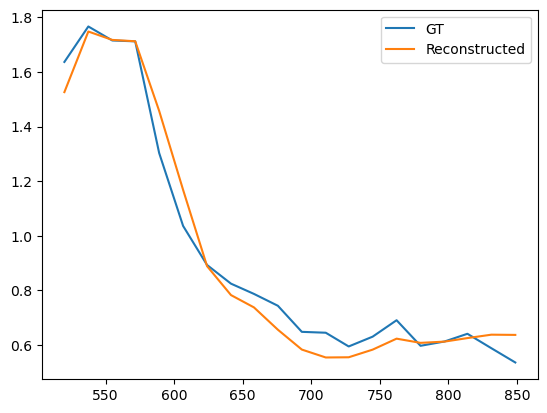

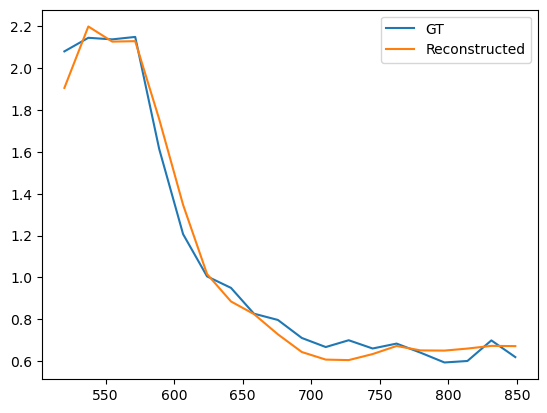

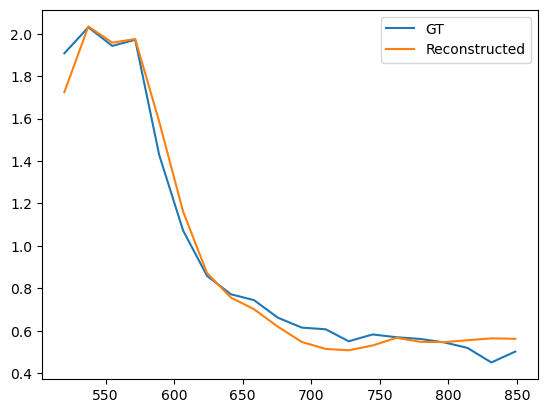

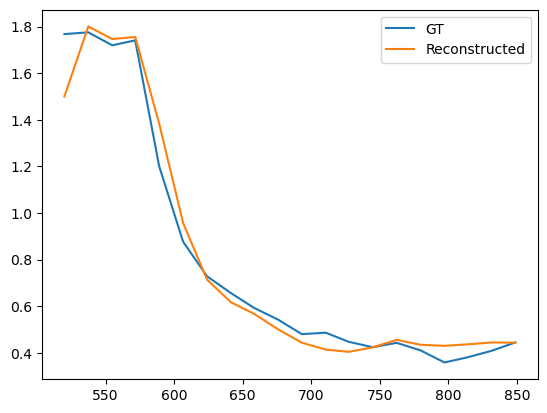

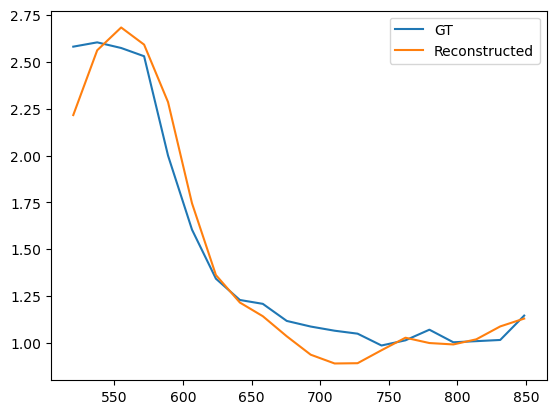

In [57]:
A_reconstr_real = mcs_obj1.A_blood_fraction(loader.wavelengths, mu_a_matrix, params_mcs_flat_real[:6,:], *params_mcs_flat_real[-2:,:])
for i in range(np.count_nonzero(test_mask)):
    plot_spectra((A_gt_img[:, test_mask][:, i], A_reconstr_real[:, i]), loader.wavelengths, labels=["GT", "Reconstructed"])
    print(params_mcs_flat_real[:, i])